<h1> Malaria Datset </h1>

<p> Malaria is a fatal disease spread to humans by the bite of Anopheles mosquitos. Malaria parasites mature, reproduce, and grow in the human liver, where they transmit disease to red blood cells, resulting in life-threatening symptoms.
We propose using CNN models for cell picture classification since CNN is capable of identifying and labelling a wide range of complicated properties.</p>

In [12]:
import warnings
warnings.filterwarnings('ignore') # to ignore any warning you might see in the code

<h4> Explore Dataset </h4>

<p>The dataset is taken from the Kaggle website https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria. Data classes are divided into two categories. Malaria is diagnosed using these data. The first class contains non-parasitic data, while the second contains parasitic data. There are 13780 parasite data and 13780 healthy data in this data collection
</p>

In [13]:

parasite = r"D:\Data Science\cell_images\Parasitized"
unaffected= r"D:\Data Science\cell_images\Uninfected"


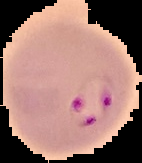

In [14]:
from PIL import Image  
Image.open("D:\Data Science\cell_images\Parasitized/C33P1thinF_IMG_20150619_114756a_cell_179.png")

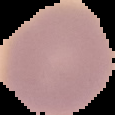

In [15]:
from PIL import Image  
Image.open(r"D:\Data Science\cell_images\Uninfected/C1_thinF_IMG_20150604_104722_cell_9.png")

In [21]:
import os

# Get all subdirectories of data directory "cell_images" folder. Each subdirectory represents a label.
directories = [d for d in os.listdir(r"D:\Data Science\cell_images")] 
directories

['Parasitized', 'Uninfected']

<h4> Preprocess the Dataset </h4>

<p> Load all the images into one dataset and resize all the images to same size so that model gives better results.

</p>

In [29]:
import cv2 
import numpy as np


# Loop through the label subdirectories and collect the data in two lists, 
# one list for labels themselves and one list for the images inside those label folders.
labels = []
images = []

category = 0 # this is tp label the data baased on the subdirectory number
for d in directories:
    label_dir = os.path.join(r"D:\Data Science\cell_images", d)
    # get all the image files (all .png) in each subdirectory
    file_names = [os.path.join(label_dir, f) for f in os.listdir(label_dir) if f.endswith(".png")]
    
  
    for f in file_names:
        img = cv2.imread(f)
        imresize = cv2.resize(img, (200, 125))
        images.append(imresize)
        labels.append(category)
        
            
    category += 1 
    

In [30]:
images = np.array(images)
images.shape

(27558, 125, 200, 3)

In [31]:
labels = np.array(labels)
labels.shape

(27558,)

<h4> Split the dataset </h4>
<p> Once data was pre processed according to the model slpit the dataset into training and test datasets. Training dataset consists of 80% of data and remaining 20% in test dataset
</p>

In [32]:
from sklearn.model_selection import train_test_split # Package used to split the dataset

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=1234)

In [33]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(22046, 125, 200, 3)
(22046,)
(5512, 125, 200, 3)
(5512,)


<p> Before feeding the images to the model,
all the images have been normalized from a value range of 0-
255 to 0-1. The labels of the images have been converted
using one-hot encoding. 

</p>

In [34]:
from tensorflow.keras.utils import to_categorical

X_train = np.array(X_train).astype('float32')
X_test = np.array(X_test).astype('float32')
X_train /= 255.0
X_test /= 255.0

# one-hot encoding of the labels
y_train = np.array(y_train)
y_test = np.array(y_test)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [35]:
print(y_train.shape)

(22046, 2)


In [36]:
num_classes = y_train.shape[1]
print(num_classes)

2


<h4> Model Building </h4>

In [108]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Dropout, MaxPooling2D, Flatten

# Create the model
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(125, 200, 3), activation='relu'))
model.add(Dropout(0.2))
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
#model.add(Dense(64, activation='softmax'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax')) # num_classes = 8

# Compile model
epochs = 12  # Ideally epochs value should be more but due to my system configuration taking 12 
lr = 0.01 # learning rate
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 123, 198, 32)      896       
                                                                 
 dropout_2 (Dropout)         (None, 123, 198, 32)      0         
                                                                 
 conv2d_3 (Conv2D)           (None, 121, 196, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 60, 98, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 188160)            0         
                                                                 
 dense_2 (Dense)             (None, 16)                3010576   
                                                      

In [109]:
from tensorflow.keras.callbacks import EarlyStopping

callback = EarlyStopping(monitor='loss', patience=3)

seed = 1234
np.random.seed(seed)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=100, callbacks=[callback])


print(len(history.history['loss']))

Epoch 1/12
221/221 [==============================] - 988s 4s/step - loss: 0.7693 - accuracy: 0.6062 - val_loss: 0.6253 - val_accuracy: 0.6491
Epoch 2/12
221/221 [==============================] - 892s 4s/step - loss: 0.4572 - accuracy: 0.8080 - val_loss: 0.2781 - val_accuracy: 0.9272
Epoch 3/12
221/221 [==============================] - 890s 4s/step - loss: 0.2762 - accuracy: 0.9148 - val_loss: 0.2256 - val_accuracy: 0.9305
Epoch 4/12
221/221 [==============================] - 1280s 6s/step - loss: 0.2162 - accuracy: 0.9291 - val_loss: 0.2117 - val_accuracy: 0.9340
Epoch 5/12
221/221 [==============================] - 897s 4s/step - loss: 0.1694 - accuracy: 0.9408 - val_loss: 0.2143 - val_accuracy: 0.9360
Epoch 6/12
221/221 [==============================] - 890s 4s/step - loss: 0.1368 - accuracy: 0.9506 - val_loss: 0.2230 - val_accuracy: 0.9278
Epoch 7/12
221/221 [==============================] - 892s 4s/step - loss: 0.1128 - accuracy: 0.9561 - val_loss: 0.2451 - val_accuracy: 0.929

<h4> Model Evaluation </h4>

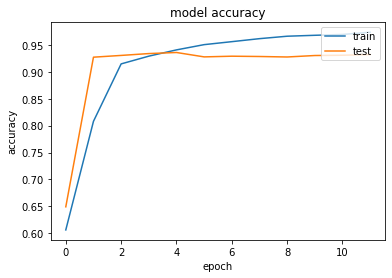

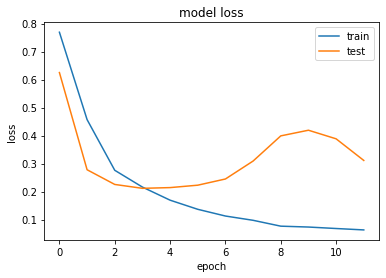

In [139]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [111]:
from sklearn.metrics import classification_report

preds = model.predict(X_test)
print(preds.shape) # which means the predictions return in one-hot encoding format
preds = np.argmax(preds, axis=1)
print(preds.shape)
y_true = np.argmax(y_test, axis=1)
print(y_test.shape)
print(classification_report(y_true, preds, target_names=directories))

(5512, 2)
(5512,)
(5512, 2)
              precision    recall  f1-score   support

 Parasitized       0.92      0.94      0.93      2730
  Uninfected       0.94      0.92      0.93      2782

    accuracy                           0.93      5512
   macro avg       0.93      0.93      0.93      5512
weighted avg       0.93      0.93      0.93      5512



In [118]:
preds1 = model.predict(X_test)

In [119]:
y_test

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [120]:
y_test1 = y_test.argmax(axis=1)

In [124]:
preds1=preds1.argmax(axis=1)

In [125]:
preds1

array([0, 0, 1, ..., 0, 0, 0], dtype=int64)

Confusion Matrix


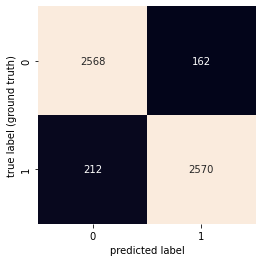

In [142]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
mat = confusion_matrix(y_test1, preds1)
print('Confusion Matrix')
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('predicted label')
plt.ylabel('true label (ground truth)')
plt.show()

In [126]:
from sklearn.metrics import accuracy_score
score = accuracy_score(y_test1,preds1)
score

0.9321480406386067

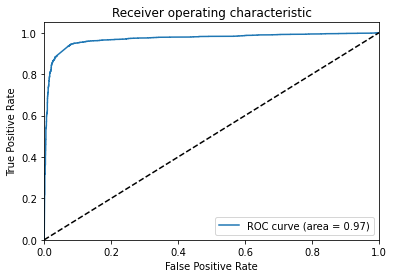

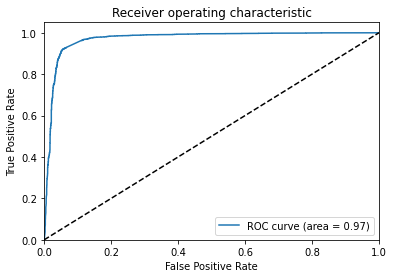

In [127]:
# Compute ROC curve and ROC area for each class
from sklearn.metrics import roc_curve, auc

y_score = model.predict(X_test) # get the prediction probabilities

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i],_ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Plot of a ROC curve for a specific class
for i in range(num_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

<h4> Fine tuning the model </h4>

In [129]:
# Step 1: import the pretrained model weights
from tensorflow.keras.applications import Xception

base_model = Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(125, 200, 3), # your input_shape preferablly to have the same as the original pretrained model
    include_top=False)  # Do not include the ImageNet classifier at the top.

In [130]:
# Step 2: Set trainable to false since you are not gonna retrain the model but will use its pretrained weights instead

base_model.trainable = False

In [132]:
# Step 3: Create your model on top
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import GlobalAveragePooling2D

inputs = Input(shape=(125, 200, 3))
x = base_model(inputs, training=False)
x1 = GlobalAveragePooling2D()(x)
outputs = Dense(num_classes, activation='softmax')(x1)
model = Model(inputs, outputs)

In [133]:
!pip install keras-tuner --upgrade

In [134]:
import keras_tuner as kt

In [136]:
# Step 1: build the model and compile it with the parametrs you want to optimise and search through using: 
# hp.choice('units', [8,16,32])

def build_model(hp):
    # Create the model
    model = Sequential()
    model.add(Conv2D(hp.Choice('filters', [8, 16, 32]), kernel_size=(3, 3), input_shape=(125, 200, 3), activation='relu'))
    model.add(Dropout(0.2))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax')) # num_classes = 8
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
    

In [137]:
# Step 2: use RandomSearch from keras_tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5)

INFO:tensorflow:Reloading Oracle from existing project .\untitled_project\oracle.json
INFO:tensorflow:Reloading Tuner from .\untitled_project\tuner0.json


In [138]:
# Step 3: start the search
tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))
best_model = tuner.get_best_models()[0]

Trial 3 Complete [01h 27m 55s]
val_loss: 0.6931560039520264

Best val_loss So Far: 0.6911245584487915
Total elapsed time: 02h 40m 56s
INFO:tensorflow:Oracle triggered exit


<h2> Conclusion </h2>
<p>
The CNN model takes a lot of time in executing the single epoch. To execute this it requires good amount of system configuration such as GPU, processor and RAM. As this program was executed in low system configuration number of epochs has been minimised removed some layers due to which the accuracy was 93%. But there is a chance of getting higher accuracy when the limit of epochs was between 25 to 30. However the loss function is around 0.6 for both the models which implies CNN has classified accurately for the malaria dataset. We can conclude that CNN is the best model in classifying images of parasitzed and healthy cells in malaria dataset.

</p>